In [1]:
import opmap
import os
import copy
import numpy as np
from scipy import stats
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
from opmap.RawCam import RawCam
from opmap.VmemMap import VmemMap
from opmap.PhaseMap import PhaseMap
from opmap.PhaseVarianceMap import PhaseVarianceMap
from opmap.util import makeMovie

%matplotlib inline

In [2]:
dirs = ['030719NIF/NIF S023RM.1@@', '030722NIF/NIF1 S014RM.1@@',
        '030722NIF/NIF2 S017RM.1@@', '030722NIF/NIF3 S020RM.1@',
        '030722NIF/NIF4 S021RM.1@', '030811NIF/S011RM.1@']

In [3]:
parents_path = '/mnt/recordings/ExperimentData'
passed_list = []
nonpassed_list = []

In [4]:
def count_pixcel(data, roi, list):
    for i in range(128):
        for j in range(128):
            if roi[i, j] == 1 and data[i, j] != 0:
                list.append(data[i, j])
    return list

def plot_bar(nonpassed_value, passed_value):
    passed_y = np.average(passed_value)
    nonpassed_y = np.average(nonpassed_value)
    passed_e = np.sqrt(np.var(passed_value))
    nonpassed_e = np.sqrt(np.var(nonpassed_value))
    res = stats.ttest_ind(np.array(passed_value), np.array(nonpassed_value), equal_var = False)
    print("t value")
    print(res)
    plt.bar(1, nonpassed_y, align='center', color='royalblue', yerr=nonpassed_e, ecolor='black')
    plt.bar(2, passed_y, align='center', color='royalblue', yerr=passed_e, ecolor='black')
    plt.xticks([1,2], [u'非旋回通過領域', u'旋回通過領域'], fontproperties=prop, size=20)
    plt.ylabel(u'累積位相分散の平均値', size=20, fontproperties=prop)
    plt.yticks(np.arange(0, 0.11, 0.01))

In [5]:
threshold = 0.8

for (n, dir) in enumerate(dirs):
    print(dir)
    APV_array = np.zeros((128, 128))
    result_path = os.path.join(parents_path, dir)
    
    rawcam = RawCam(path=result_path, cam_type='max', image_height=256, image_width=256, frame_start=200, frame_end=1300)
    rawcam.setRectROI(top=50)
    rawcam.setIntROI(val_min=50)
    rawcam.morphROI(erosion=20)

    vmap = VmemMap(rawcam)
    vmap.smooth(size=2)
    pmap = PhaseMap(vmap, shrink=2)
    pvmap = PhaseVarianceMap(pmap)
        
    phase_variance_array = copy.deepcopy(pvmap.data)[:-100, :, :]
    ROI = copy.deepcopy(pvmap.roi)
    
    core = (phase_variance_array > threshold) * 1
    core_count = np.sum(core, axis=0)
    
    for i in range(128):
        for j in range(128):
            if ROI[i,j] != 0:
                data = copy.deepcopy(phase_variance_array[:, i, j])
                while np.max(data) > threshold:
                    x_pos = np.argmax(data)
                    x_max = x_pos + 1
                    x_min = x_pos - 1
                    while x_max < 1000 and data[x_max - 1] > data[x_max]:
                        x_max += 1
                    while x_min > -1 and data[x_min] < data[x_min + 1]:
                        x_min -= 1
                    data[x_min+2:x_max] = 0
                APV_array[i,j] = np.sum(data)/len(np.nonzero(data)[0])
                if core_count[i,j] > 0:
                    passed_list.append(APV_array[i,j])
                else:
                    nonpassed_list.append(APV_array[i,j])
    
    plt.imshow(core_count, cmap='jet')
    #plt.colorbar()
    plt.savefig('/mnt/recordings/AnalysisResult/Seno/opmap/APV/20170901/without_colorbar/core/core_%s.png' % n, dpi=300, transparent=True)
    plt.close()
    
    plt.imshow(APV_array, cmap='jet')
    #plt.colorbar()
    plt.savefig('/mnt/recordings/AnalysisResult/Seno/opmap/APV/20170901/without_colorbar/APV/APV_%s.png' % n, dpi=300, transparent=True)
    plt.close()

030719NIF/NIF S023RM.1@@


AssertionError: 

# 結果画像

In [267]:
passed_weights = np.ones_like(passed_list)/float(len(passed_list))
nonpassed_weights = np.ones_like(nonpassed_list)/float(len(nonpassed_list))
plt.hist(passed_list, bins=1000, range=(0, 0.2), alpha=0.5, color='r', histtype='stepfilled', weights=passed_weights)
plt.hist(nonpassed_list, bins=1000, range=(0, 0.2), alpha=0.3, color='b', histtype='stepfilled', weights=nonpassed_weights)
plt.xlabel('Phase Variance vaule', size=15)
plt.ylabel('Ratio', size=15)
plt.xlim([0,0.2])
plt.xticks(size=12)
plt.yticks(size=12)
#plt.title('Histograms', size=20)
labels = ['passed', 'nonpassed']
plt.legend(labels, fontsize=15)
plt.tight_layout()
plt.savefig('/mnt/recordings/AnalysisResult/Seno/opmap/APV/20170901/histogram/histogram.png', dpi=300, transparent=True)
plt.close()

In [217]:
np.save('/mnt/recordings/AnalysisResult/Seno/opmap/APV/20170901/other/passed.npy', np.asarray(passed_list))
np.save('/mnt/recordings/AnalysisResult/Seno/opmap/APV/20170901/other/nonpassed.npy', np.asarray(nonpassed_list))

In [244]:
print('a number:\n%s' % len(passed_list))
print('a average:\n%s' % np.average(passed_list))
print('a var:\n%s' % np.var(passed_list))
print('b number:\n%s' % len(nonpassed_list))
print('b average:\n%s' % np.average(nonpassed_list))
print('b var:\n%s' % np.var(nonpassed_list))

a number:
7808
a average:
0.0323016307831
a var:
0.000531642027346
b number:
24885
b average:
0.0202758732037
b var:
0.000342738879672


In [248]:
t_value = (np.average(passed_list)-np.average(nonpassed_list)) / np.sqrt((np.var(passed_list)/len(passed_list))+(np.var(nonpassed_list)/len(nonpassed_list)))
print(t_value)

42.0310702104


# アルゴリズム確認

In [135]:
np.argmax(phase_variance_array[:, 70, 40])

524

In [ ]:
"""
core = (phase_variance_array > 0.8) * 1
core_count = np.sum(core, axis=0)
core = (phase_variance_array > 0.6) * 1
without_core = 1 - core
dat = phase_variance_array * without_core
average = np.sum(dat, axis=0) / np.sum(without_core, axis=0)
core = (core_count > 0) * 1
without_core = 1 - core
passed_ave = average * core
nonpassed_ave = average * without_core
"""

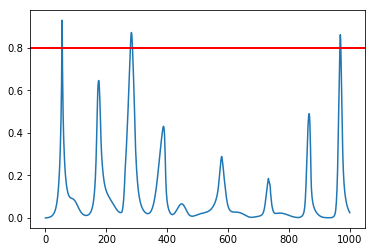

In [257]:
plt.plot(phase_variance_array[:, 100, 60])
plt.axhline(y=0.8, xmin=0, xmax=1000, linewidth=2, color = 'r')

In [260]:
threshold = 0.8
test = copy.deepcopy(phase_variance_array[:, 100, 60])
print(np.max(test))
while np.max(test) > threshold:
    x_pos = np.argmax(test)
    x_max = x_pos + 1
    x_min = x_pos - 1
    while (x_max < 1000) and (test[x_max - 1] > test[x_max]):
        x_max += 1
    while (x_min > -1) and (test[x_min] < test[x_min + 1]):
        x_min -= 1
    test[x_min+2:x_max] = 0

0.928694


In [263]:
plt.plot(phase_variance_array[:, 100, 60])
plt.axhline(y=0.8, xmin=0, xmax=1000, linewidth=2, color = 'r')
plt.xlim([0, 1000])
plt.ylim([0, 1.0])
plt.ylabel('Phase Variance value', size=16)
plt.xlabel('Time (ms)', size=16)
plt.tight_layout()
plt.savefig('/mnt/recordings/AnalysisResult/Seno/opmap/APV/20170901/other/before.png', dpi=300)
plt.close()

In [264]:
plt.plot(test)
plt.axhline(y=0.8, xmin=0, xmax=1000, linewidth=2, color = 'r')
plt.xlim([0, 1000])
plt.ylim([0, 1.0])
plt.ylabel('Phase Variance value', size=16)
plt.xlabel('Time (ms)', size=16)
plt.tight_layout()
plt.savefig('/mnt/recordings/AnalysisResult/Seno/opmap/APV/20170901/other/after.png', dpi=300)
plt.close()

In [63]:
np.sum(test)/len(np.nonzero(test)[0])

0.073668839901028058

In [2]:
rawcam = RawCam(path='/mnt/recordings/ExperimentData/030719NIF/NIF S023RM.1@@', cam_type='max', image_height=256, image_width=256, frame_start=200, frame_end=1300)
rawcam.setRectROI(top=50)
rawcam.setIntROI(val_min=50)
rawcam.morphROI(erosion=20)

vmap = VmemMap(rawcam)
vmap.smooth(size=2)
pmap = PhaseMap(vmap, shrink=2)
pvmap = PhaseVarianceMap(pmap)

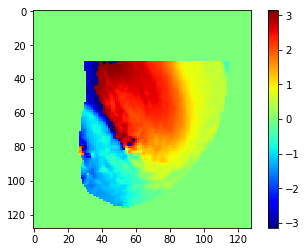

In [11]:
plt.imshow(pmap.data[500, :, :], vmin=-np.pi, vmax=np.pi, cmap=pmap.cmap)
plt.colorbar()
#plt.savefig('/mnt/recordings/AnalysisResult/Seno/opmap/example.png', dpi=300)